In [13]:
import matplotlib.pyplot as plt
import pandas as pd

import pypsa

%matplotlib inline

In [14]:
# use 24 hour period for consideration
index = pd.date_range("2016-01-01 00:00", "2016-01-01 23:00", freq="h")

# consumption pattern of BEV
bev_usage = pd.Series([0.0] * 7 + [9.0] * 2 + [0.0] * 8 + [9.0] * 2 + [0.0] * 5, index)

# solar PV panel generation per unit of capacity
pv_pu = pd.Series(
    [0.0] * 7
    + [0.2, 0.4, 0.6, 0.75, 0.85, 0.9, 0.85, 0.75, 0.6, 0.4, 0.2, 0.1]
    + [0.0] * 5,
    index,
)

# availability of charging - i.e. only when parked at office
charger_p_max_pu = pd.Series(0, index=index)
charger_p_max_pu["2016-01-01 09:00":"2016-01-01 16:00"] = 1.0

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

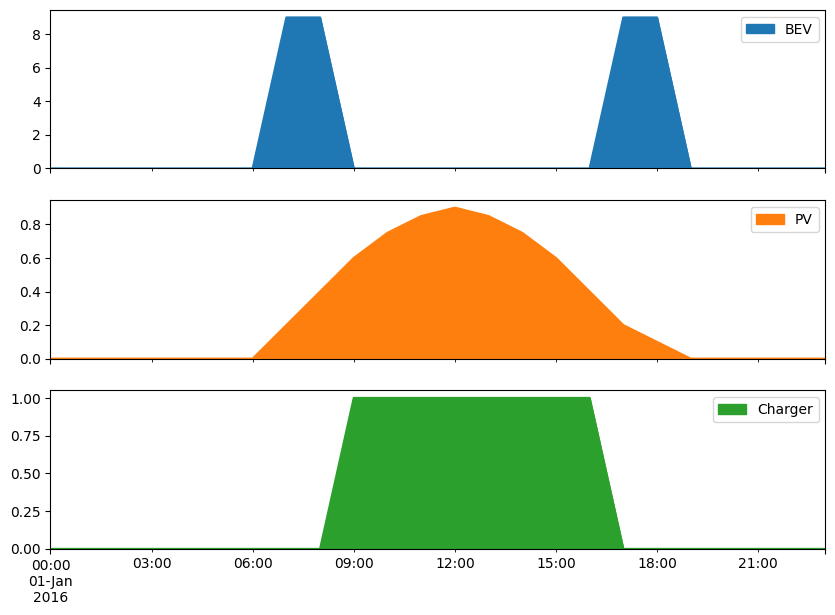

In [15]:
df = pd.concat({"BEV": bev_usage, "PV": pv_pu, "Charger": charger_p_max_pu}, axis=1)
df.plot.area(subplots=True, figsize=(10, 7))


In [16]:
# df.plot.area(subplots=True, figsize=(10, 7))
# plt.tight_layout()

In [17]:
network = pypsa.Network()
network.set_snapshots(index)

network.add("Bus", "place of work", carrier="AC")

network.add("Bus", "battery", carrier="Li-ion")

network.add(
    "Generator",
    "PV panel",
    bus="place of work",
    p_nom_extendable=True,
    p_max_pu=pv_pu,
    capital_cost=1000.0,
)

network.add("Load", "driving", bus="battery", p_set=bev_usage)

network.add(
    "Link",
    "charger",
    bus0="place of work",
    bus1="battery",
    p_nom=120,  # super-charger with 120 kW
    p_max_pu=charger_p_max_pu,
    efficiency=0.9,
)


network.add("Store", "battery storage", bus="battery", e_cyclic=True, e_nom=100.0)

In [18]:
network.optimize(solver_name="highs")
print("Objective:", network.objective)

Index(['place of work', 'battery'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='Store')
Index(['charger'], dtype='object', name='Link')
Index(['place of work', 'battery'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='Store')
Index(['charger'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 97 primals, 217 duals
Objective: 7.02e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+00]
  Cost   [1e+03, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [9e+00, 1e+02]
Presolving model
16 rows, 17 cols, 40 nonzeros  0s
11 rows, 12 cols, 30 nonzeros  0s
9 rows, 10 cols, 24 nonzeros  0s
9 rows, 9 cols, 24 nonzeros  0s
Presolve : Reductions: rows 9(-208); columns 9(-88); elements 24(-301)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(36) 0s
          9     7.0175438596e+03 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 9
Objective value     :  7.0175438596e+03
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/linopy-solve-apaa368x.sol
Objective: 7017.543859649122


In [19]:
network.generators.p_nom_opt["PV panel"]

7.017543859649122

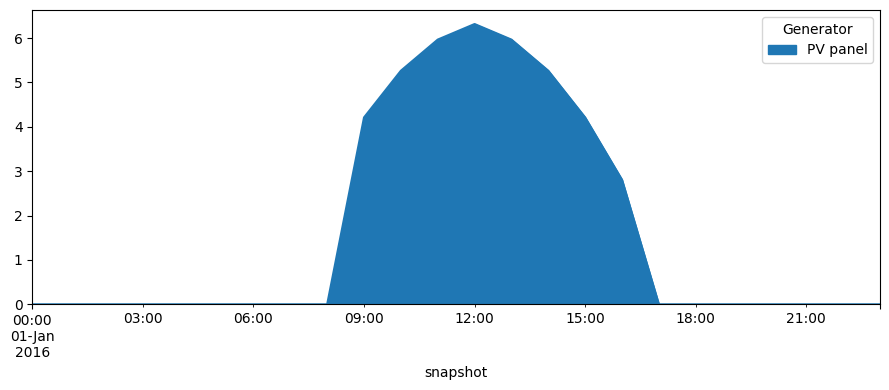

In [20]:
network.generators_t.p.plot.area(figsize=(9, 4))
plt.tight_layout()

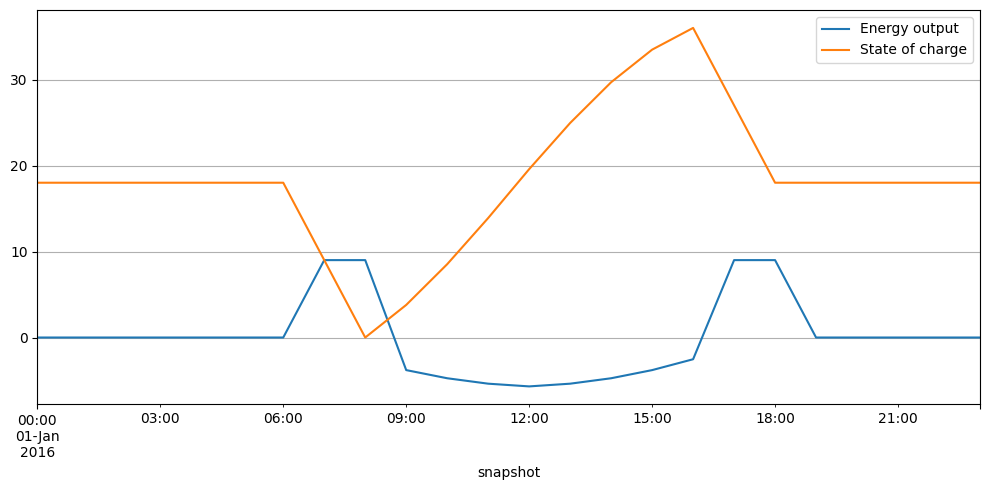

In [21]:
df = pd.DataFrame(
    {attr: network.stores_t[attr]["battery storage"] for attr in ["p", "e"]}
)
df.plot(grid=True, figsize=(10, 5))
plt.legend(labels=["Energy output", "State of charge"])
plt.tight_layout()

In [22]:

(
    network.generators_t.p.loc[:, "PV panel"].sum()
    - network.loads_t.p.loc[:, "driving"].sum()
)

4.0

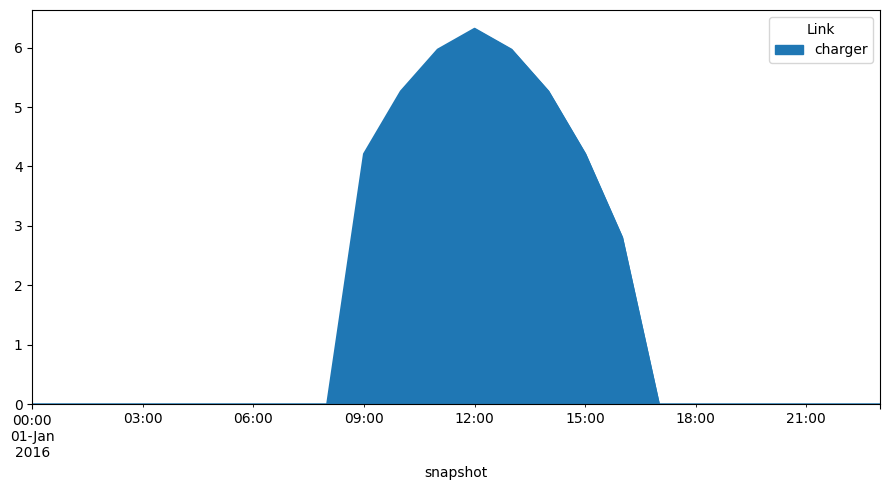

In [23]:
network.links_t.p0.plot.area(figsize=(9, 5))
plt.tight_layout()